In [1]:
%matplotlib inline
import numpy as np
from sklearn.covariance import empirical_covariance

from regain.utils import structure_error
from regain import datasets
from regain.covariance.missing_time_graphical_lasso import MissingTimeGraphicalLasso
from regain.covariance.time_graphical_lasso_ import TimeGraphicalLasso

from sklearn.datasets.base import Bunch
import rpy2
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects

import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

# import R's "base" package
glasso = importr('cglasso')


# config
np.random.seed(0)
n_samples = 100
T = 10
beta = 1

In [2]:
from regain.covariance.time_graphical_lasso_ import time_graphical_lasso
from sklearn.impute import SimpleImputer

In [52]:
from tqdm import tqdm
import time
import warnings 

warnings.simplefilter('ignore')
results = {}



kernel = np.zeros((T, T))
for i in range(T-1):
    kernel[i, i+1] = beta


thetas = []
for n_dim_obs in tqdm(np.logspace(1, 2, 5)):
    res, elapsed_time = [], []
    res1, elapsed_time1 = [], []
    res2, elapsed_time2 = [], []
    
    res3, elapsed_time3 = [], []
    tt = [] 
    
    alpha = np.log(n_dim_obs)/n_samples
    for i in range(10):
        mgl = MissingTimeGraphicalLasso(alpha=alpha, kernel=kernel, psi='laplacian', 
                                        tol=1e-3, rtol=1e-3, verbose=0, max_iter=500)
        tgl = TimeGraphicalLasso(alpha=alpha,  beta=beta, psi='laplacian', 
                                 tol=1e-3, rtol=1e-3,verbose=0, max_iter=500)

        n_dim_obs = int(n_dim_obs)
        dataset = datasets.make_dataset(n_samples=n_samples, n_dim_lat=0, update_ell='fixed',
                        update_theta='l2', normalize_starting_matrices=True, n_dim_obs=n_dim_obs, T=10)
        tt.append(dataset.thetas)
        
        to_remove = int(T*n_samples*n_dim_obs*0.1)
        X = dataset.X
        X[np.random.choice(np.arange(0, T*n_samples), to_remove),
          np.random.choice(np.arange(0, n_dim_obs), to_remove)] = np.nan

        
        tic = time.time()
        results_static = mgl.fit(X, dataset.y).precision_
        tac = time.time() - tic    
        res.append(results_static)
        elapsed_time.append(tac)
        
        y = dataset.y
        #inputing
        emp_cov = np.array([empirical_covariance(
                            SimpleImputer(strategy='mean').fit_transform(X[y == cl]),
                            assume_centered=True)
                            for cl in np.unique(y) ])
        tic = time.time()
        precision_inputing = time_graphical_lasso(emp_cov, alpha=alpha,  beta=beta, psi='laplacian', 
                                 tol=1e-3, rtol=1e-3,verbose=0, max_iter=50)
        tac = time.time() - tic  
        res1.append(precision_inputing[0])
        elapsed_time1.append(tac)
        
        # Complete cases 
        Xs = [X[y==cl] for cl in np.unique(y)]
        Xs = [x[~np.isnan(x).any(axis=1)] for x in Xs]
        emp_cov = np.array([empirical_covariance(x,
                            assume_centered=True)
                            for x in Xs ])
     #   print(Xs)
        try:
            tic = time.time()
            precision_inputing = time_graphical_lasso(emp_cov, alpha=alpha,  beta=beta, psi='laplacian', 
                                     tol=1e-3, rtol=1e-3,verbose=0, max_iter=50)
            tac = time.time() - tic  
            res3.append(precision_inputing[0])
            elapsed_time3.append(tac)
        except ValueError:
            continue
        
        try:
            tic = time.time()
            thetas_res = []
            for t in range(T):
                aaa = X[t*n_samples:(t+1)*n_samples,:]
                result = glasso.mglasso(robjects.r.matrix(aaa, nrow=aaa.shape[0], ncol=aaa.shape[1]), 
                       nrho=2, rho=robjects.FloatVector(list([alpha])), thr_em = 1e-3, thr_bcd = 1e-3)
                result = list(result)
                A = np.array(list(result[16]))
                A = A.reshape((n_dim_obs,n_dim_obs,1))
                thetas_res.append(A[:,:,-1])
                                #robjects.r.matrix(np.zeros((n_dim_obs, n_dim_lat)), nrow=n_dim_obs, ncol=n_dim_lat))
            tac = time.time() - tic
            res2.append(thetas_res)
            elapsed_time2.append(tac)
        except rpy2.rinterface.RRuntimeError:
            continue
    thetas.append(tt)
    results[('mtgl', n_dim_obs)] = dict(res=res, elapsed_time=elapsed_time)
    results[('tgl(inputing)', n_dim_obs)] = dict(res=res1, elapsed_time=elapsed_time1)
    results[('mglasso', n_dim_obs)] = dict(res=res2, elapsed_time=elapsed_time2)
    results[('tgl(complete)', n_dim_obs)] = dict(res=res3, elapsed_time=elapsed_time3)













  0%|          | 0/5 [00:00<?, ?it/s]











 20%|██        | 1/5 [00:35<02:22, 35.54s/it]











 40%|████      | 2/5 [01:43<02:15, 45.28s/it]











 60%|██████    | 3/5 [04:10<02:31, 75.67s/it]











 80%|████████  | 4/5 [11:17<03:01, 181.23s/it]











100%|██████████| 5/5 [34:47<00:00, 417.54s/it]


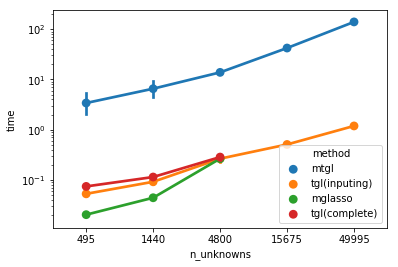

In [116]:
import pandas as pd
from regain.utils import flatten

rcParams.update({'font.size': 10})
df = pd.DataFrame(
    flatten([[(k[0], T*int(k[1] * k[1]-1) // 2 * 1, x) 
              for x in results[k]['elapsed_time']] for k in results]),
    columns=['method', 'n_unknowns', 'time'])

import seaborn as sns
from matplotlib import pyplot as plt
f, ax = plt.subplots()
plt.yscale("log")
g = sns.pointplot(data=df, hue='method', x='n_unknowns', y='time')
plt.savefig("../results_tmgl/scalability_partial_data_10_percent_missing.pdf", dpi=200, bbox_inches='tight',
           transparent=True)

In [61]:
from regain.utils import mean_structure_error


mat_results = np.zeros((5, 4))
for i, t in enumerate(thetas):
    _,d, _ = t[0].shape
   # print(results[('mgl', d)])
    a1 = float(mean_structure_error(t, [np.array(r) for r in results[('mtgl', d)]['res']], multiple=True)['mcc'].split('+/-')[0])
    mat_results[i, 0] = a1
    a2 = float(mean_structure_error(t, [np.array(r) for r in results[('tgl(inputing)', d)]['res']], multiple=True)['mcc'].split('+/-')[0])
    mat_results[i, 1] = a2
    a2 = float(mean_structure_error(t, [np.array(r) for r in results[('tgl(complete)', d)]['res']], multiple=True)['mcc'].split('+/-')[0])
    mat_results[i, 2] = a2
    
    a3 = float(mean_structure_error(t, [np.array(r) for r in results[('mglasso', d)]['res']], multiple=True)['mcc'].split('+/-')[0])
    mat_results[i, 3] = a3

In [93]:
results

{('mtgl',
  10): {'res': [array([[[ 1.43111766e+00,  4.07335146e-01,  4.10128961e-01,
            -1.18400890e-02, -0.00000000e+00,  0.00000000e+00,
            -8.73411481e-02,  0.00000000e+00, -5.64865774e-03,
             3.85785810e-01],
           [ 4.07335146e-01,  1.57511724e+00,  0.00000000e+00,
             3.92480867e-01,  1.92107723e-02,  3.41685195e-02,
             7.20028830e-02, -2.84858556e-03, -0.00000000e+00,
             2.75715587e-01],
           [ 4.10128961e-01,  0.00000000e+00,  1.25480549e+00,
            -3.97799488e-03, -9.12557151e-02,  0.00000000e+00,
             1.89537186e-01,  0.00000000e+00,  2.59305153e-01,
            -0.00000000e+00],
           [-1.18400890e-02,  3.92480867e-01, -3.97799488e-03,
             1.73384173e+00, -7.48084966e-04, -7.23622928e-03,
            -9.67419976e-02, -1.72262707e-02,  5.40348311e-01,
            -6.96775770e-02],
           [-0.00000000e+00,  1.92107723e-02, -9.12557151e-02,
            -7.48084966e-04,  1.633052

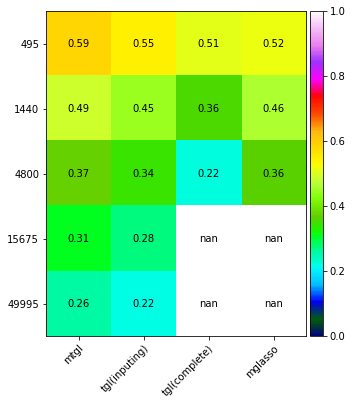

In [90]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(5,8))
im = ax.imshow(mat_results, vmin=0, vmax=1, cmap='gist_ncar')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)


# We want to show all ticks...
ax.set_xticks(np.arange(4))
ax.set_yticks(np.arange(5))
# ... and label them with the respective list entries
ax.set_xticklabels(['mtgl', 'tgl(inputing)', 'tgl(complete)', 'mglasso'])
ax.set_yticklabels(np.unique(df['n_unknowns']))

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(5):
    for j in range(4):
        text = ax.text(j, i, round(mat_results[i, j],2),
                       ha="center", va="center", color="k")

#ax.set_title("Harvest of local farmers (in tons/year)")
fig.tight_layout()
plt.savefig("../results_tmgl/MCC_partial_data_10_percent_missing.pdf", dpi=200, bbox_inches='tight',
           transparent=True)
plt.show()

In [70]:
from regain.utils import mean_structure_error


mat_results_std = np.zeros((5, 4))
for i, t in enumerate(thetas):
    _,d, _ = t[0].shape
   # print(results[('mgl', d)])
    a1 = float(mean_structure_error(t, [np.array(r) for r in results[('mtgl', d)]['res']], multiple=True)['mcc'].split('+/-')[1])
    mat_results_std[i, 0] = a1
    a2 = float(mean_structure_error(t, [np.array(r) for r in results[('tgl(inputing)', d)]['res']], multiple=True)['mcc'].split('+/-')[1])
    mat_results_std[i, 1] = a2
    a2 = float(mean_structure_error(t, [np.array(r) for r in results[('tgl(complete)', d)]['res']], multiple=True)['mcc'].split('+/-')[1])
    mat_results_std[i, 2] = a2
    
    a3 = float(mean_structure_error(t, [np.array(r) for r in results[('mglasso', d)]['res']], multiple=True)['mcc'].split('+/-')[1])
    mat_results_std[i, 3] = a3

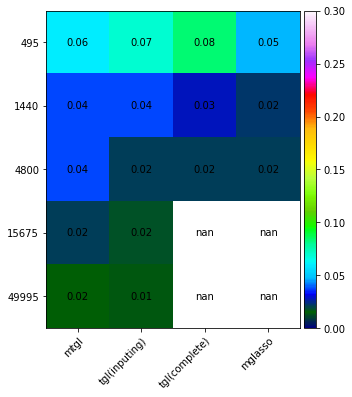

In [113]:
fig, ax = plt.subplots(figsize=(5,8))

from matplotlib import rcParams
rcParams.update({'font.size': 10})
im = ax.imshow(mat_results_std, vmin=0, vmax=0.3, cmap='gist_ncar')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

# We want to show all ticks...
ax.set_xticks(np.arange(4))
ax.set_yticks(np.arange(5))
# ... and label them with the respective list entries
ax.set_xticklabels(['mtgl', 'tgl(inputing)', 'tgl(complete)', 'mglasso'])
ax.set_yticklabels(np.unique(df['n_unknowns']))

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(5):
    for j in range(4):
        text = ax.text(j, i, round(mat_results_std[i, j],2),
                       ha="center", va="center", color="k")

#ax.set_title("Harvest of local farmers (in tons/year)")
fig.tight_layout()
plt.savefig("../results_tmgl/MCC_STD_partial_data_10_percent_missing.pdf", dpi=200, bbox_inches='tight',
           transparent=True)
plt.show()

In [95]:
import pickle as pkl 

with open("../results_tmgl/results_10_percent.pkl", "wb") as f:
    pkl.dump(results, f)


with open("../results_tmgl/thetas_10_percent.pkl", "wb") as f:
    pkl.dump(thetas,f)

# ROC CURVES

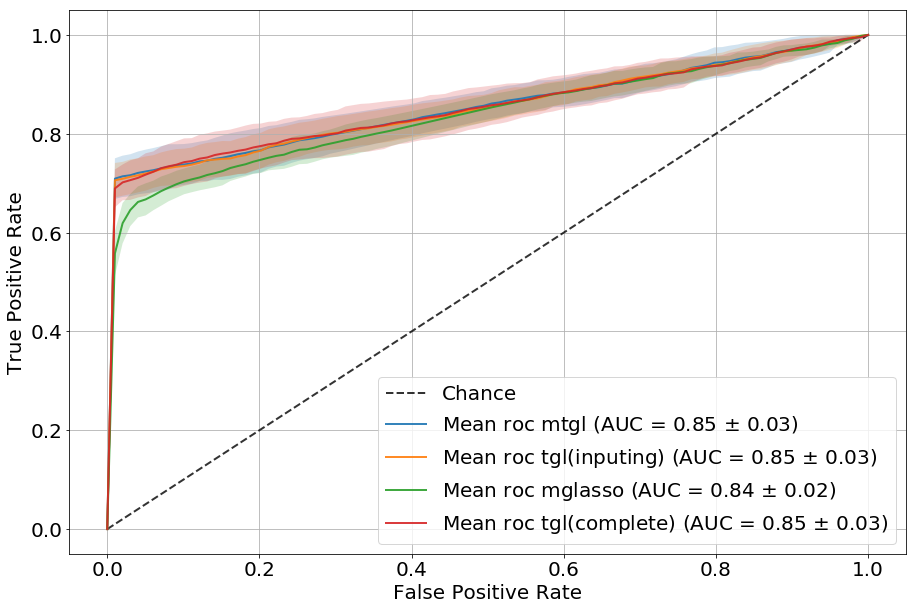

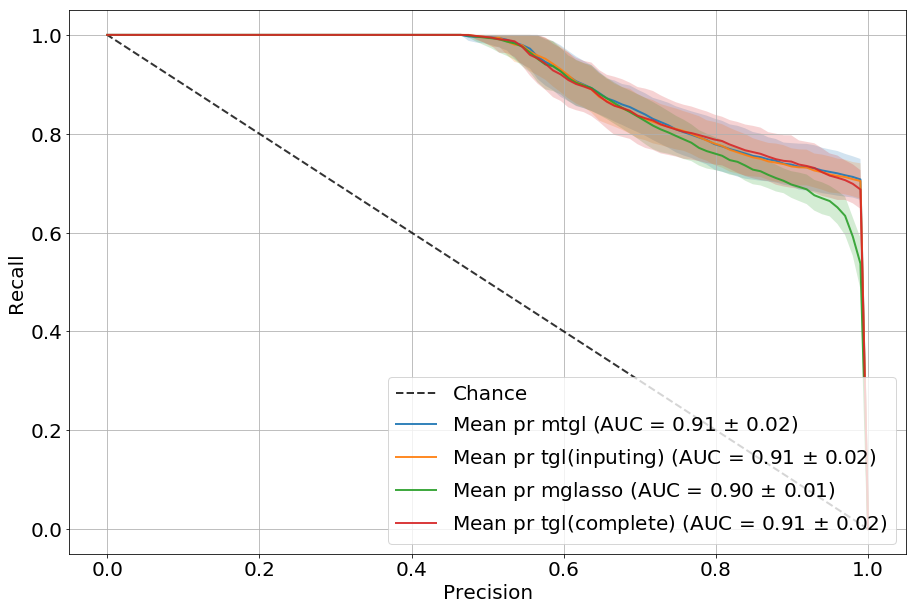

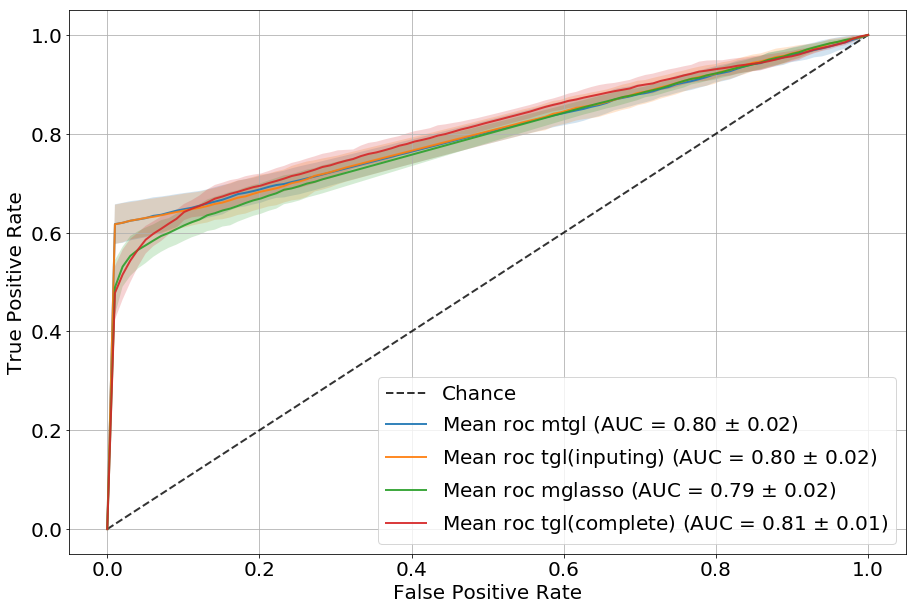

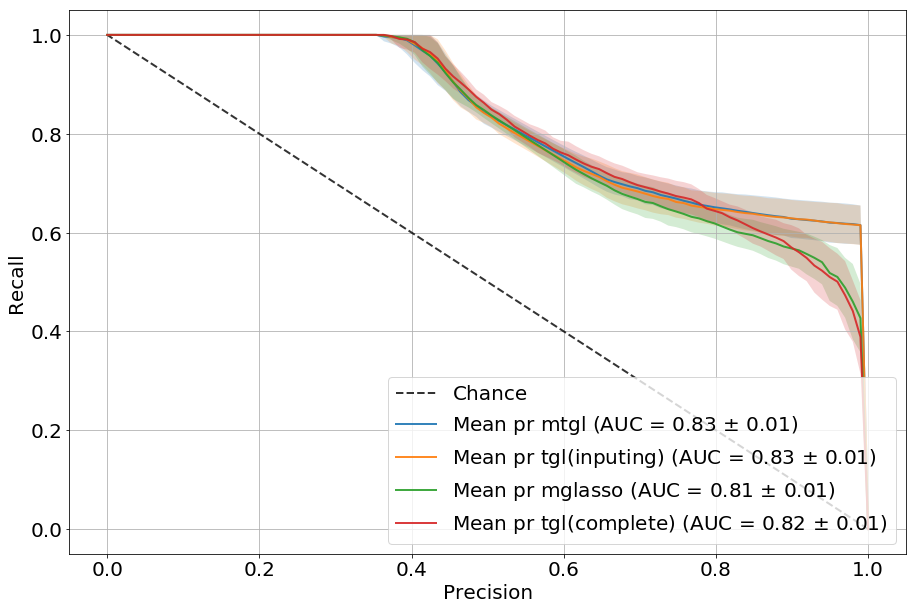

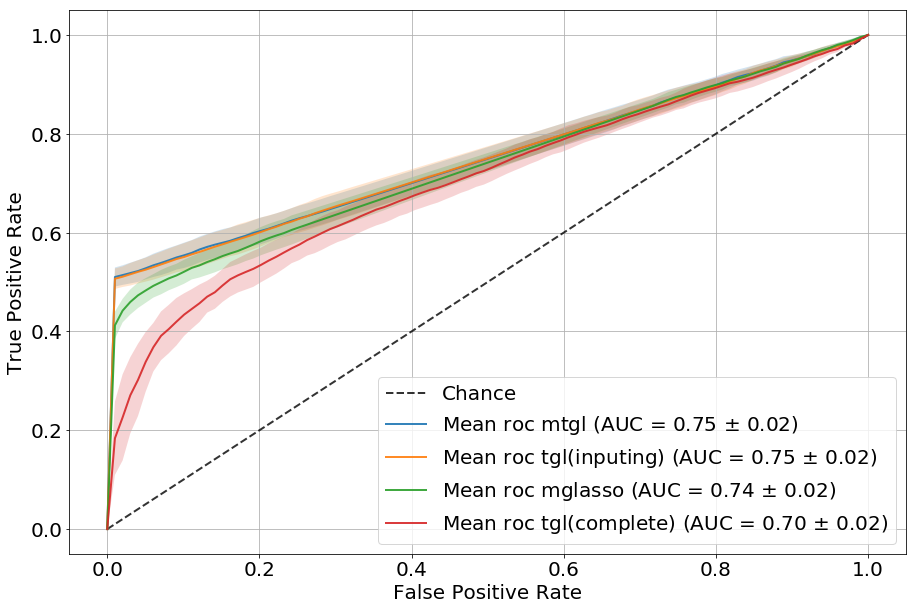

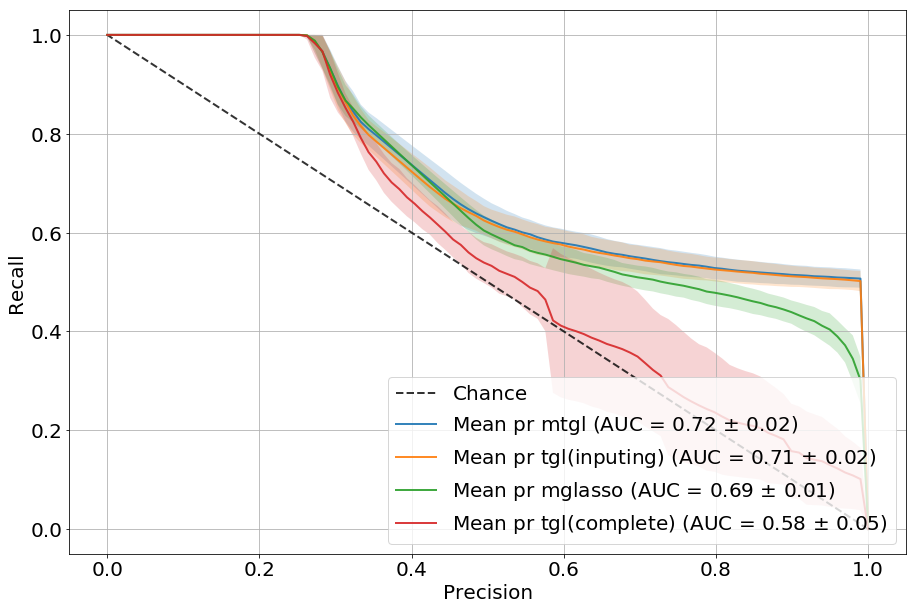

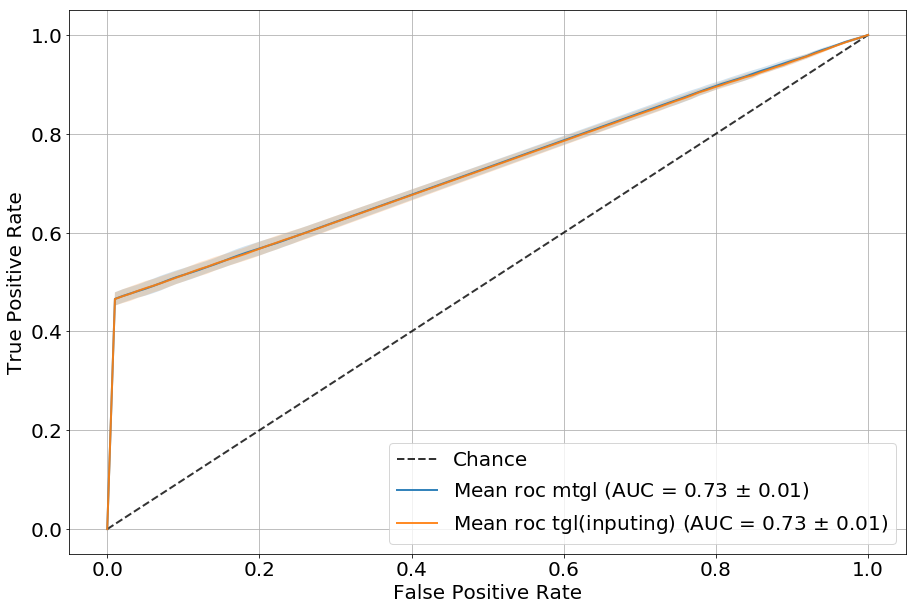

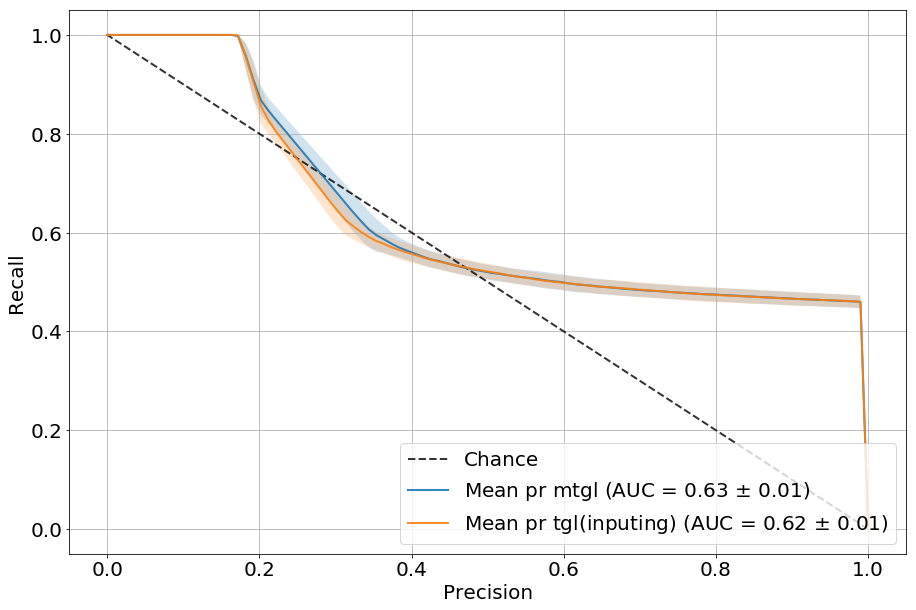

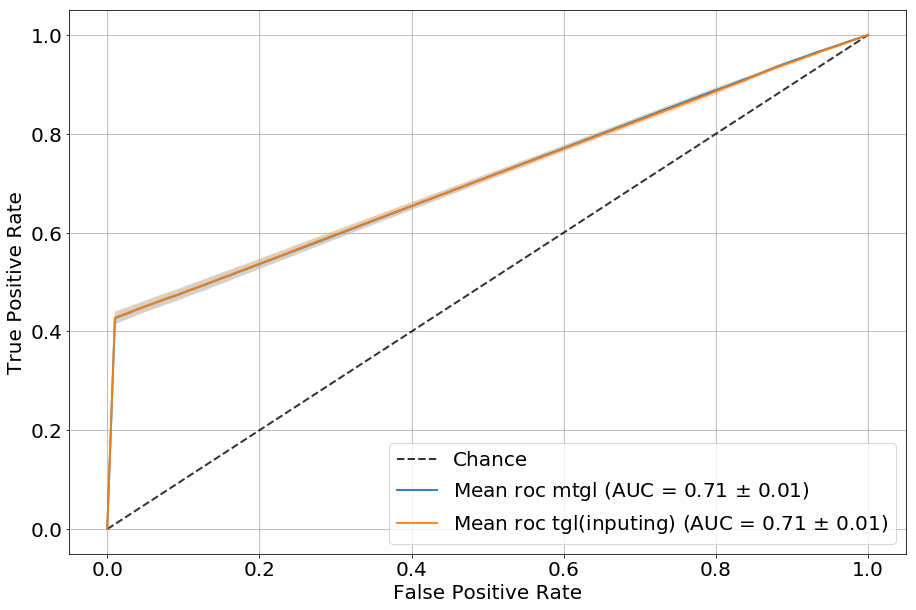

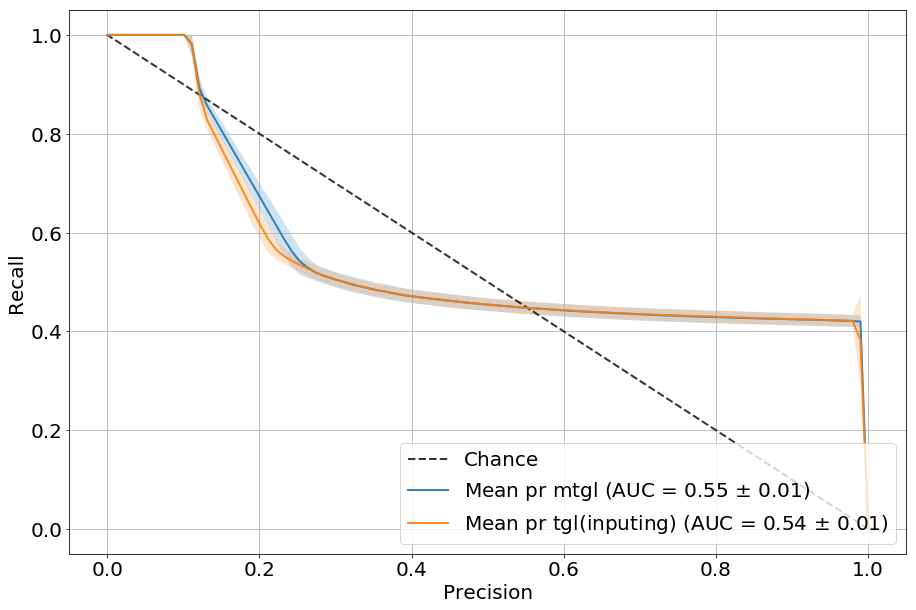

In [114]:
from regain.plotting.results import plot_curve

for t in thetas:
    _,d, _ = t[0].shape
    if d < 50:
        _dict = {'mtgl': [np.array(r) for r in results[('mtgl',d )]['res']], 
                           'tgl(inputing)': [np.array(r) for r in results[('tgl(inputing)',d )]['res']],
                           'mglasso': [np.array(r) for r in results[('mglasso',d )]['res']],
                'tgl(complete)': [np.array(r) for r in results[('tgl(complete)',d )]['res']],
                           }
    else:
        _dict = {'mtgl': [np.array(r) for r in results[('mtgl',d )]['res']], 
                           'tgl(inputing)': [np.array(r) for r in results[('tgl(inputing)',d )]['res']]}
    plot_curve(t, _dict, multiple=True, filename="../results_tmgl/roc_curve_10_percent_"+str(d)+"dimensions.pdf",
              fontsize=20)
    plot_curve(t, _dict, multiple=True, filename="../results_tmgl/roc_curve_10_percent_"+str(d)+"dimensions.pdf",
              fontsize=20, mode='pr')

In [108]:
plot_curve??